In [ ]:
# %% [markdown]
"""
# 01_curve_qc.py — lightweight QC notebook

VS Code treats `# %%` blocks as Jupyter cells, so you can **Run All** or step
through interactively.  The notebook

* stitches **curve_history.parquet** and **curve_live.parquet**
* derives simple features (level & slope)
* fetches daily BTC‑USD prices from Yahoo Finance
* plots funding‑level vs. price and a slope ↔ next‑day‑return scatter.

Place this file at **project‑root/notebooks/01_curve_qc.py**.
"""
# %%
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
# %% [markdown]

In [ ]:
# %%  Load curve snapshots  -------------------------------
from pathlib import Path
import pandas as pd
from pandas.tseries.frequencies import to_offset

ROOT = Path.cwd()                 # notebook’s working dir  ← fix
# If you always launch VS Code from the project root, this is correct.
# Otherwise:  ROOT = Path(__file__).parents[2]  ← works in .py script, not notebook

curve_hist_path = ROOT / "storage" / "processed" / "curve_history.parquet"
curve_live_path = ROOT / "storage" / "processed" / "curve_live.parquet"

# read history
df_curve = pd.read_parquet(curve_hist_path, engine="fastparquet")
if curve_live_path.exists():
    df_curve = pd.concat(
        [df_curve, pd.read_parquet(curve_live_path, engine="fastparquet")],
        ignore_index=True,
    )

df_curve["ts_snap"] = pd.to_datetime(df_curve["ts_snap"], utc=True)
df_curve = df_curve.sort_values("ts_snap")

# choose a single exchange (Binance) for first pass
curve_bn = df_curve[df_curve["exchange"] == "binance"].copy()

# tidy → wide: one column per bucket
curve_w = (
    curve_bn.pivot_table(
        index="ts_snap", columns="bucket_start_h", values="fwd_rate_ann"
    )
    .add_prefix("b_")
    .sort_index()
)

# basic derived factors
curve_w["level"] = curve_w["b_0"]
curve_w["slope"] = curve_w["b_56"] - curve_w["b_0"]
curve_w = curve_w.dropna(subset=["level", "slope"])  # ensure complete rows
# %% [markdown]

In [ ]:
# %%  Download BTC close & attach to every bucket row  -----------------------

import pandas as pd
import yfinance as yf
from datetime import timedelta

# --- B1.  download BTC-USD closes ------------------------------------------
start_date = curve_w.index.get_level_values(0).min().strftime("%Y-%m-%d")
end_date   = (curve_w.index.get_level_values(0).max() + timedelta(days=1)).strftime("%Y-%m-%d")

btc = (
    yf.download("BTC-USD", start=start_date, end=end_date, progress=False)
      .loc[:, ["Close"]]
      .rename(columns={"Close": "btc_close"})
)
btc.index = btc.index.tz_localize("UTC")

# --- B2.  broadcast price to MultiIndex ------------------------------------
btc_aligned = btc.reindex(curve_w.index.get_level_values(0), method="ffill")

curve_full = curve_w.copy()
curve_full["btc_close"]  = btc_aligned.values
curve_full["btc_ret_1d"] = curve_full["btc_close"].pct_change().shift(-1)

display(curve_full.head(12))    # shows 8 buckets per ts_snap


,b_0,b_8,b_16,b_24,b_32,b_40,b_48,b_56,level,slope,BTC-USD,btc_close,btc_ret_1d
ts_snap,,,,,,,,,,,,,
2021-01-03 08:00:00+00:00,2.510388,2.510388,2.510388,2.510388,2.510388,2.510388,2.510388,2.510388,2.510388,0.0,32782.023438,32782.023438,0.000000
2021-01-03 16:00:00.002000+00:00,4.452104,4.452104,4.452104,4.452104,4.452104,4.452104,4.452104,4.452104,4.452104,0.0,32782.023438,32782.023438,-0.024712
2021-01-04 00:00:00+00:00,5.023729,5.023729,5.023729,5.023729,5.023729,5.023729,5.023729,5.023729,5.023729,0.0,31971.914062,31971.914062,0.000000
2021-01-04 08:00:00+00:00,12.282148,12.282148,12.282148,12.282148,12.282148,12.282148,12.282148,12.282148,12.282148,0.0,31971.914062,31971.914062,0.000000
2021-01-04 16:00:00+00:00,0.848783,0.848783,0.848783,0.848783,0.848783,0.848783,0.848783,0.848783,0.848783,0.0,31971.914062,31971.914062,0.063197
2021-01-05 00:00:00.020000+00:00,1.629711,1.629711,1.629711,1.629711,1.629711,1.629711,1.629711,1.629711,1.629711,0.0,33992.429688,33992.429688,0.000000
2021-01-05 08:00:00.003000+00:00,0.675893,0.675893,0.675893,0.675893,0.675893,0.675893,0.675893,0.675893,0.675893,0.0,33992.429688,33992.429688,0.000000
2021-01-05 16:00:00.003000+00:00,0.990891,0.990891,0.990891,0.990891,0.990891,0.990891,0.990891,0.990891,0.990891,0.0,33992.429688,33992.429688,0.083311
2021-01-06 00:00:00.010000+00:00,3.022398,3.022398,3.022398,3.022398,3.022398,3.022398,3.022398,3.022398,3.022398,0.0,36824.363281,36824.363281,0.000000


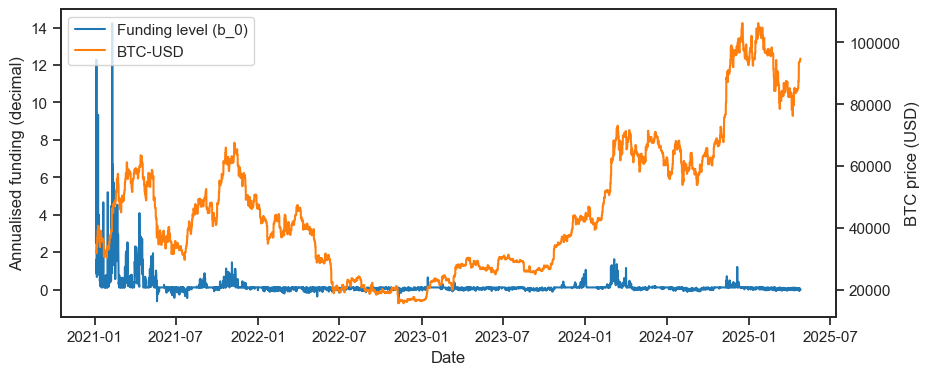

In [ ]:
# %% Plot bucket-0 funding level vs. BTC price  -----------------------------
import matplotlib.pyplot as plt

# 1) make a tidy DataFrame with just the two series we need
plot_df = (
    curve_full[["b_0", "btc_close"]]
      .rename(columns={"b_0": "funding_b0_ann"})
)

# 2) build dual-axis plot
fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()

ax1.plot(plot_df.index, plot_df["funding_b0_ann"],
         label="Funding level (b_0)", color="tab:blue")
ax2.plot(plot_df.index, plot_df["btc_close"],
         label="BTC-USD", color="tab:orange")

ax1.set_ylabel("Annualised funding (decimal)")
ax2.set_ylabel("BTC price (USD)")
ax1.set_xlabel("Date")

# combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.show()



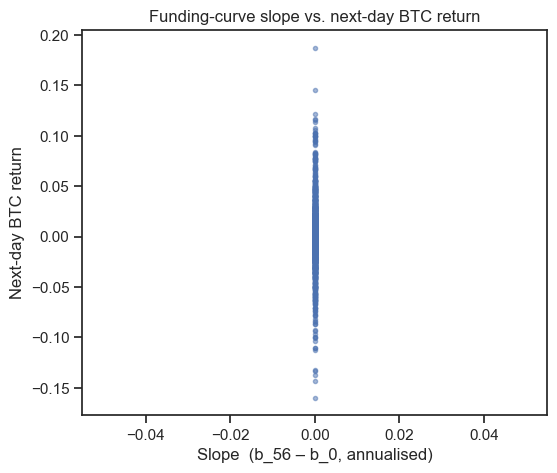

Notebook finished ✅ – curves, price, and scatter plotted.


In [ ]:
# %% Plot 2 – funding-slope vs. next-day BTC return  ------------------------
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------------------
# 0.  Ensure helper columns exist
# --------------------------------------------------------------------------
if "slope" not in curve_full.columns:
    curve_full["slope"] = curve_full["b_56"] - curve_full["b_0"]

if "btc_ret_1d" not in curve_full.columns:
    curve_full["btc_ret_1d"] = curve_full["btc_close"].pct_change().shift(-1)

# --------------------------------------------------------------------------
# 1.  Build a tidy DataFrame with *one row per timestamp*
#     • If index has 2 levels, pick bucket-0 rows.
#     • If index has 1 level, use the frame as-is.
# --------------------------------------------------------------------------
if curve_full.index.nlevels == 2:
    bucket0_mask = curve_full.index.get_level_values(1) == 0
    tidy_df = (
        curve_full[bucket0_mask]
          .droplevel(1)           # drop bucket level
          .reset_index()          # ts_snap -> column
    )
else:  # already single-level
    tidy_df = curve_full.reset_index()

# --------------------------------------------------------------------------
# 2.  Scatter plot
# --------------------------------------------------------------------------
plt.figure(figsize=(6, 5))
plt.scatter(tidy_df["slope"], tidy_df["btc_ret_1d"], alpha=0.5, s=9)
plt.xlabel("Slope  (b_56 – b_0, annualised)")
plt.ylabel("Next-day BTC return")
plt.title("Funding-curve slope vs. next-day BTC return")

finite_mask = np.isfinite(tidy_df["slope"]) & np.isfinite(tidy_df["btc_ret_1d"])
x = tidy_df.loc[finite_mask, "slope"].values
y = tidy_df.loc[finite_mask, "btc_ret_1d"].values

if len(np.unique(x)) > 1:                    # need ≥2 distinct x values
    m, b = np.polyfit(x, y, deg=1)
    xg   = np.linspace(x.min(), x.max(), 200)
    plt.plot(xg, m * xg + b,
             color="tab:red", lw=0.8, alpha=0.8, label="OLS trend")
    plt.legend(loc="upper left")
# ------------------------------------

plt.show()
print("Notebook finished ✅ – curves, price, and scatter plotted.")



In [44]:
# %% Visualise funding-curve factors vs. next-day BTC return  ----------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style="ticks")

# ------------------------------------------------------------------ #
# 1.  Load feature store + attach returns
# ------------------------------------------------------------------ #
feat = pd.read_parquet("storage/processed/feature_store.parquet",
                       engine="fastparquet")

# If you already have btc_ret_1d in curve_full, merge it; else compute here
if "btc_ret_1d" not in feat.columns:
    # quick Yahoo close fetch for the same date span
    import yfinance as yf
    closes = (
        yf.download(
            "BTC-USD",
            start=feat.index.min().strftime("%Y-%m-%d"),
            end  =(feat.index.max() + pd.Timedelta(days=1)).strftime("%Y-%m-%d"),
            progress=False,
        )
        .loc[:, ["Close"]]                      # keep only the Close column
        .rename(columns={"Close": "btc_close"}) # rename properly with a dict
        .tz_localize("UTC")
    )

feat["btc_close"]  = closes.reindex(feat.index, method="ffill")
feat["btc_ret_1d"] = feat["btc_close"].pct_change().shift(-1)
feat = feat.dropna(subset=["btc_ret_1d"])